In [0]:
import pandas as pd
import numpy as np
import random
import time
import re
import statistics as stats
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from keras.layers.advanced_activations import LeakyReLU, PReLU

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.utils import class_weight

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [0]:
data = pd.read_csv('ks-projects-201801.csv', encoding = 'ISO-8859-1')

In [0]:
# only use a subset of our whole dataset
length = len(data['goal'])
subset = length - 20000 # if we only want 20,000 rows

data = data.iloc[0:length-subset]

In [0]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [0]:
# number of days between launch data and deadline
def duration_of_project():
    duration = []
    comp = []
    
    for launch, deadline in zip(data['launched'], data['deadline']):
        
        launch = (launch.split())[0]
        launchT = [x.strip() for x in launch.split('-')]
        deadlineT = [x.strip() for x in deadline.split('-')]
    
        year_diff = (int(deadlineT[0]) - int(launchT[0]))*365
        month_diff = (int(deadlineT[1]) - int(launchT[1]))*30
        day_diff = int(deadlineT[2]) - int(launchT[2])
    
        days_offset = year_diff + month_diff + day_diff
        duration.append(days_offset)
        comp.append(launchT[0] + launchT[1])
        
    data['duration'] = duration
    data['launch_time'] = comp

In [0]:
duration_of_project()

In [0]:
data['state'].replace(['canceled'], ['failed'], inplace=True)
data['state'].replace(['failed', 'successful'], [-1, 1], inplace=True)

In [0]:
data['state_binary'] = data['state']
data['state_binary'].replace([-1, 1], [0, 1], inplace=True)

In [0]:
slim_data = data.copy()
indexNames = slim_data[ (slim_data['state_binary'] != 1) & (slim_data['state_binary'] != 0) ].index
slim_data.drop(indexNames , inplace=True)

In [0]:
# find length of name
name_length = []
for name in slim_data['name']:
    try:
        name_length.append(len(name))
    except:
        name_length.append(0)
slim_data['name_len'] = name_length

In [0]:
for launch in slim_data['launch_time'].unique():
    time = np.where(slim_data['launch_time'] == launch)
    
    for row in time[0]:
        slim_data.loc[slim_data.index[row], 'gen_comp'] = len(time[0])

In [0]:
slim_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,launch_time,state_binary,name_len,gen_comp
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,-1,0,GB,0.0,0.0,1533.95,58,201508,0,31,287.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,-1,15,US,100.0,2421.0,30000.00,59,201709,0,45,216.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,-1,3,US,220.0,220.0,45000.00,44,201301,0,14,163.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,-1,1,US,1.0,1.0,5000.00,29,201203,0,49,194.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,-1,14,US,1283.0,1283.0,19500.00,55,201507,0,58,304.0


In [0]:
categories = ['Art','Comics','Crafts','Dance','Design','Fashion','Film & Video','Food','Games','Journalism','Music','Photography','Publishing','Technology','Theater']
g = slim_data[['main_category', 'state_binary', 'usd pledged']].groupby(['main_category', 'state_binary']).agg(['count'])
g.mean
# 30 groups
count_arr = []
success_rate_arr= []
for x in g:
    print(x)
    for i in range (30):
        var = g[x][i]
        count_arr.append(g[x][i])
comp_list = [x * 2 for x in range(15)]
for i in comp_list:
    rate = count_arr[i+1]/(count_arr[i]+count_arr[i+1])
    success_rate_arr.append(rate) 
# success rate for each main cat
success_rate = {}
for cat,suc in zip(categories,success_rate_arr):
    success_rate[cat] = suc*100
for dic in success_rate:
    print (dic, success_rate[dic])
# number of projects funded (in thousands)
success_projects_funded_arr = []
funded = {}
for i in comp_list:
    success_projects_funded_arr.append(count_arr[i+1])
for cat,suc in zip(categories,success_projects_funded_arr):
    funded[cat] = suc/1000
# dollars on successful projects
g = slim_data[['main_category', 'state_binary', 'usd pledged']].groupby(['main_category', 'state_binary'])[['usd pledged']].sum()
pledged_arr = []
for x in g:
    print(x)
    for i in range (30):
        var = g[x][i]
        pledged_arr.append(g[x][i])
success_dollars_pledged_arr = []
pos_dollars = {}
for i in comp_list:
    success_dollars_pledged_arr.append(pledged_arr[i+1])
for cat,suc in zip(categories,success_dollars_pledged_arr):
    pos_dollars[cat] = suc/1000000

('usd pledged', 'count')
Art 41.98675496688742
Comics 54.35168738898757
Crafts 24.686192468619247
Dance 59.375
Design 34.70967741935484
Fashion 25.520833333333332
Film & Video 37.94241151769646
Food 26.31578947368421
Games 36.5814696485623
Journalism 17.857142857142858
Music 49.45862335653519
Photography 29.47368421052631
Publishing 29.940417080436944
Technology 21.951219512195124
Theater 62.04620462046204
usd pledged


In [0]:
# success rate based on size of goal

# dictionaries where key is category
less_than_1 = {} # less than 1000
less_than_10 = {} # less than 10000
less_than_20 = {} # less than 20000
less_than_100 = {} # less than 100000
less_than_1m = {} # less than 1000000
m_plus = {} # greater than 1000000

kick_stats = open('pledge_success.txt')
for line in kick_stats:

    line = line.strip("\n")
    entry = re.split(r'\t+', line)
    for itr in range(1, len(entry)):
        entry[itr] = float(entry[itr].replace(",", "."))
    
    cat = str(entry[0])
    print(cat)
    total = entry[1]
    _1 = entry[2] / total
    _10 = entry[3] / total
    _20 = entry[4] / total
    _100 = entry[5] / total
    _1m = entry[6] / total
    _m = entry[7] / total
    
    less_than_1[cat] = _1
    less_than_10[cat] = _10
    less_than_20[cat] = _20
    less_than_100[cat] = _100
    less_than_1m[cat] = _1m
    m_plus[cat] = _m

Music
Film & Video
Games
Publishing
Art
Design
Technology
Comics
Fashion
Theater
Food
Photography
Dance
Crafts
Journalism


In [0]:
slim_data['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [0]:
# add a column that specifies if a project's goal is above the mean  
# for its category
for cat in slim_data['main_category'].unique():
    print(cat)
    this_cat = np.where(slim_data['main_category'] == cat)
    
    # find mean of the category
    mean_goal = 0
    #mean_backers = []
    for row in this_cat[0]:
        mean_goal += slim_data.iloc[row]['goal']
        #mean_backers.append(slim_data.iloc[row]['backers'])
    mean_goal = mean_goal / len(this_cat[0])
    
    for row in this_cat[0]:
    
        # add column for mean of goal of each category
        slim_data.loc[slim_data.index[row], 'cat_mean'] = mean_goal
        
        # add column for success rate
        slim_data.loc[slim_data.index[row], 'success_rate'] = success_rate[cat]
        
        # add column for positive dollars raised
        slim_data.loc[slim_data.index[row], 'pos_dollars'] = pos_dollars[cat]
        
        # add column for funded projects in category
        slim_data.loc[slim_data.index[row], 'funded_in_cat'] = funded[cat]
        
        # add column for diff of mean and current
        goal_diff = mean_goal - slim_data.iloc[row]['goal']
        slim_data.loc[slim_data.index[row], 'cat_goal_diff'] = goal_diff
        
        # add columns for success rate for category based on goal
        # apply success rate to project
        if slim_data.iloc[row]['usd_goal_real'] < 1000:
            slim_data.loc[slim_data.index[row], '1k_succ_rate'] = less_than_1[cat]
            slim_data.loc[slim_data.index[row], '10k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '20k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '100k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '1m_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], 'm+_succ_rate'] = 0
            
        elif slim_data.iloc[row]['usd_goal_real'] < 10000:
            slim_data.loc[slim_data.index[row], '1k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '10k_succ_rate'] = less_than_10[cat]
            slim_data.loc[slim_data.index[row], '20k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '100k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '1m_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], 'm+_succ_rate'] = 0
            
        elif slim_data.iloc[row]['usd_goal_real'] < 20000:
            slim_data.loc[slim_data.index[row], '1k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '10k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '20k_succ_rate'] = less_than_20[cat]
            slim_data.loc[slim_data.index[row], '100k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '1m_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], 'm+_succ_rate'] = 0
            
        elif slim_data.iloc[row]['usd_goal_real'] < 100000:
            slim_data.loc[slim_data.index[row], '1k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '10k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '20k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '100k_succ_rate'] = less_than_100[cat]
            slim_data.loc[slim_data.index[row], '1m_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], 'm+_succ_rate'] = 0
            
        elif slim_data.iloc[row]['usd_goal_real'] < 1000000:
            slim_data.loc[slim_data.index[row], '1k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '10k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '20k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '100k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '1m_succ_rate'] = less_than_1m[cat]
            slim_data.loc[slim_data.index[row], 'm+_succ_rate'] = 0
            
        elif slim_data.iloc[row]['usd_goal_real'] > 1000000:
            slim_data.loc[slim_data.index[row], '1k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '10k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '20k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '100k_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], '1m_succ_rate'] = 0
            slim_data.loc[slim_data.index[row], 'm+_succ_rate'] = m_plus[cat]

Publishing
Film & Video
Music
Food
Design
Crafts
Games
Comics
Fashion
Theater
Art
Photography
Technology
Dance
Journalism


In [0]:
# same as above but for specific category
p_pos = p_neg = b_pos = b_neg = 0

for cat in slim_data['category'].unique():
    this_cat = np.where(slim_data['category'] == cat)
    
    # find mean of the category
    mean_goal = 0
    median_backers = []
    median_pledged = []
    b_mean = 0
    p_mean = 0
    for row in this_cat[0]:
        mean_goal += slim_data.iloc[row]['goal']
        median_backers.append(slim_data.iloc[row]['backers'])
        median_pledged.append(slim_data.iloc[row]['pledged'])
        b_mean += slim_data.iloc[row]['backers']
        p_mean += slim_data.iloc[row]['pledged']
        
    mean_goal = mean_goal / len(this_cat[0])
    median_backers = stats.median(median_backers)
    median_pledged = stats.median(median_pledged)
    b_mean = b_mean / len(this_cat[0])
    p_mean = p_mean / len(this_cat[0])
    
    mean_backers = (median_backers + b_mean) / 2
    mean_pledged = (median_pledged + p_mean) / 2
    
    #print(cat, " | ", mean_backers)
    
    for row in this_cat[0]:
        goal_diff = mean_goal - slim_data.iloc[row]['goal']
        slim_data.loc[slim_data.index[row], 'm_cat_goal_diff'] = goal_diff
        
        if slim_data.iloc[row]['pledged'] > mean_pledged*0.75:
            slim_data.loc[slim_data.index[row], 'mean_pledged_binary'] = 1
            p_pos += 1
        else:
            slim_data.loc[slim_data.index[row], 'mean_pledged_binary'] = 0
            p_neg += 1
        
        if slim_data.iloc[row]['backers'] > mean_backers:
            slim_data.loc[slim_data.index[row], 'mean_backer_binary'] = 1
            b_pos += 1
        else:
            slim_data.loc[slim_data.index[row], 'mean_backer_binary'] = 0
            b_neg += 1
            
print("p_pos", p_pos)
print("p_neg", p_neg)
print("b_pos", b_pos)
print("b_neg", b_neg)

p_pos 6209
p_neg 13340
b_pos 5814
b_neg 13735


In [0]:
slim_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,cat_goal_diff,1k_succ_rate,10k_succ_rate,20k_succ_rate,100k_succ_rate,1m_succ_rate,m+_succ_rate,m_cat_goal_diff,mean_pledged_binary,mean_backer_binary
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,-1,...,13750.631929,0.0,0.618688,0.000000,0.000000,0.0,0.0,4717.941333,0.0,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,-1,...,26114.486051,0.0,0.000000,0.000000,0.148097,0.0,0.0,31387.405694,0.0,0.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,-1,...,11114.486051,0.0,0.000000,0.000000,0.148097,0.0,0.0,16387.405694,0.0,0.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,-1,...,13167.757429,0.0,0.706030,0.000000,0.000000,0.0,0.0,21795.457602,0.0,0.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,-1,...,36614.486051,0.0,0.000000,0.157611,0.000000,0.0,0.0,70792.236395,0.0,0.0


In [0]:
slim_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19549 entries, 0 to 19999
Data columns (total 34 columns):
ID                     19549 non-null int64
name                   19549 non-null object
category               19549 non-null object
main_category          19549 non-null object
currency               19549 non-null object
deadline               19549 non-null object
goal                   19549 non-null float64
launched               19549 non-null object
pledged                19549 non-null float64
state                  19549 non-null object
backers                19549 non-null int64
country                19549 non-null object
usd pledged            19532 non-null float64
usd_pledged_real       19549 non-null float64
usd_goal_real          19549 non-null float64
duration               19549 non-null int64
launch_time            19549 non-null object
state_binary           19549 non-null object
name_len               19549 non-null int64
gen_comp               19549 non-nu

In [0]:
# scale down data columns
sc = MinMaxScaler()

slim_data['fit_goal'] = sc.fit_transform(slim_data[['goal']])
slim_data['fit_name_len'] = sc.fit_transform(slim_data[['name_len']])
slim_data['fit_duration'] = sc.fit_transform(slim_data[['duration']])
slim_data['fit_cat_mean'] = sc.fit_transform(slim_data[['cat_mean']])
slim_data['fit_goal_diff'] = sc.fit_transform(slim_data[['cat_goal_diff']])
slim_data['fit_m_cat_goal'] = sc.fit_transform(slim_data[['m_cat_goal_diff']])
slim_data['fit_s_rate'] = sc.fit_transform(slim_data[['success_rate']])
slim_data['fit_pos_dollars'] = sc.fit_transform(slim_data[['pos_dollars']])
slim_data['fit_funded'] = sc.fit_transform(slim_data[['funded_in_cat']])
slim_data['fit_gen_comp'] = sc.fit_transform(slim_data[['gen_comp']])
#slim_data['fit_sp_comp'] = sc.fit_transform(slim_data[['sp_comp']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
slim_data = slim_data.dropna()

In [0]:
# build DNN
def build_model(dims):
    model = Sequential()  # sequential layered network

    # input layer
    model.add(Dense(100, activation='linear', input_dim = dims))
    model.add(LeakyReLU(alpha=.001))
    model.add(Dropout(0.5))

    # second layer
    model.add(Dense(100, activation='linear'))
    model.add(LeakyReLU(alpha=.001))
    model.add(Dropout(0.5))


    # third layer
    model.add(Dense(100, activation='linear'))
    model.add(LeakyReLU(alpha=.01))
    model.add(Dropout(0.5))


    # fourth layer
    model.add(Dense(85, activation='linear'))
    model.add(LeakyReLU(alpha=.01))
    model.add(Dropout(0.5))


    # fith layer
    model.add(Dense(75, activation='linear'))
    model.add(LeakyReLU(alpha=.001))
    model.add(Dropout(0.5))

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile the model using rmsprop opt and mse loss
    #start = time.time()
    model.compile(optimizer = 'RMSprop',  
                  loss = 'mse',
                  metrics = ['accuracy'])

    #print("Compilation Time : ", time.time() - start)
    return model

In [0]:
training=pd.get_dummies(slim_data, columns=["main_category"])
training=pd.get_dummies(training, columns=["category"])
training=pd.get_dummies(training, columns=["country"])
training=pd.get_dummies(training, columns=["currency"])

y = slim_data['state_binary']
X = training.loc[:, '1k_succ_rate':]
X = X.drop('m_cat_goal_diff', 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [0]:
dims = len(X.columns) # dimension of the input data

model1 = build_model(dims)

# Train the model, iterating on the data in batches of 32 samples
history = model1.fit(X_train, y_train,
                    validation_split = 0.33,
                    epochs = 50,
                    batch_size = 35)

# Evaluate the model's performance
train_loss, train_acc = model1.evaluate(X_train, y_train)
test_loss, test_acc = model1.evaluate(X_test, y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Train on 10465 samples, validate on 5155 samples
Epoch 1/50
10465/10465 [==============================] - 1s 130us/step - loss: 0.1952 - acc: 0.7247 - val_loss: 0.1419 - val_acc: 0.8306
Epoch 2/50
10465/10465 [==============================] - 1s 88us/step - loss: 0.1447 - acc: 0.8279 - val_loss: 0.1327 - val_acc: 0.8336
Epoch 3/50
10465/10465 [==============================] - 1s 87us/step - loss: 0.1356 - acc: 0.8361 - val_loss: 0.1263 - val_acc: 0.8341
Epoch 4/50
10465/10465 [==============================] - 1s 85us/step - loss: 0.1305 - acc: 0.8381 - val_loss: 0.1331 - val_acc: 0.8316
Epoch 5/50
10465/10465 [==============================] - 1s 89us/step - loss: 0.1281 - acc: 0.8405 - val_loss: 0.1284 - val_acc: 0.8355
Epoch 6/50
10465/10465 [==============================] - 1s 86us/step - loss: 0.1247 - acc: 0.8437 - val_loss: 0.1278 - val_acc: 0.8359
Epoch 7/50
10465/10465 [==============================] - 1s 86us/step - loss: 0.1224 - acc: 0.8490 - val_loss: 0.1279 - val_acc

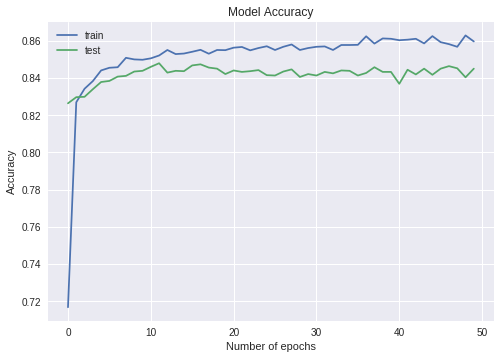

In [0]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

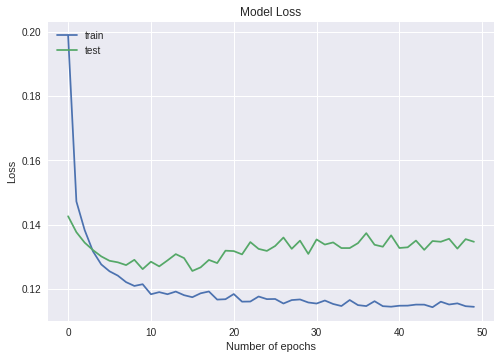

In [0]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
preds = model1.predict(X)
ytr = ptr = 0
for Y, pred in zip(y, preds):
    if Y > 0.5:
        ytr += 1
    if pred > 0.5:
        ptr += 1
print(ytr, " | ", ptr)

7107  |  7177


In [0]:
#y_pred = model1.predict(X_test)
#y_true = []
#for val in y_test:
#    y_true.append(val)
#matrix = confusion_matrix(y_true, y_pred)
#print(matrix)